# Table of Contents
1. [Parameters](#parameters)
2. [Imports](#imports)
    1. [Packages](#packages)
    2. [Data Files](#files)

## Parameters <a name="parameters"></a>

In [1]:
n_neighbors = 20
vmax = 3
vmin = -3
cmap_z = "coolwarm"  #'RdBu_r'
cmap_raw = "viridis"
ifdoublet = False
percentile_filter = 30
min_counts = 3
poor_cluster_percentile_threshold = 20
poor_cluster_zstd_threshold = 10
leiden_rsolution = .5

## Imports <a name="imports"></a>

### Packages <a name="packages"></a>

In [2]:
import re
import matplotlib.pyplot as plt
import napari
import numpy as np
import scanpy as sc
import scanpy.external as scex
import seaborn as sns
import zarr
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex

# from converting_anndata import *
from params import *

from warnings import filterwarnings

filterwarnings("ignore")

sc.settings.verbosity = 3

def anndata_copy_attributes(src_anndata, dtn_anndata):
    dtn_anndata.obs = src_anndata.obs
    dtn_anndata.uns = src_anndata.uns
    dtn_anndata.obsm = src_anndata.obsm
    dtn_anndata.obsp = src_anndata.obsp

### Data Files <a name="files"></a>

In [3]:
path = './example/expression_matrix_stitched.h5ad'
adata = sc.read_h5ad(path)

print(adata)
print(adata.var_names)
# print(adata.obs['position'])

print(f'>>> total cell number: {adata.n_obs}')

AnnData object with n_obs × n_vars = 16165 × 39
    obs: 'position', 'overlap_in_stitched', 'cell_location'
Index(['7a-5p', '433-3p', '128-3p', 'noTS', '451a', '181a-5p', '34a-5p',
       '139-5p', '1a-1', '132-5p', '221-3p', '133a-3p', '126a-3p', '204-5p',
       'sncg', 'deptor', 'reln', 'nxph4', 'rorb', 'rprm', 'chodl', 'crym',
       'lratd2', 'tac1', 'lamp5', 'pvalb', 'tpbg', 'calb1', 'tle4', 'cux1',
       'sst', 'fezf2', 'ctgf', 'foxp2', 'gad1', 'pcp4', 'slc17a7', 'vip',
       'sulf1'],
      dtype='object')
>>> total cell number: 16165


### Gene list <a name="Gene list"></a>

In [4]:
endo_list = ['sncg',
    'deptor', 'reln', 'nxph4', 'rorb',
    'rprm', 'chodl', 'crym', 
    'tac1', 'lamp5', 'pvalb', 'tpbg',
    'calb1', 'tle4', 'cux1', 'sst',
    'fezf2', 'ctgf', 'foxp2', 'gad1',
    'pcp4', 'slc17a7', 'vip', 'sulf1'

]
virus_list = [
    'noTS',   
    '1a-1', '7a-5p', '126a-3p', '128-3p', '132-5p', 
    '133a-3p','139-5p','181a-5p',
    '204-5p','221-3p', '433-3p', '451a', 
]
titer = [
    8.559, 6.629, 8.153, 6.942,
    6.497, 7.036, 6.704, 6.624, 6.287, 6.602,
    5.543, 7.221, 6.214
]

## Analysis <a name="analysis"></a>

In [5]:
# exclude cells double counted in overlapped regions between tiles
adata_virus = adata[~adata.obs['overlap_in_stitched'], adata.var_names.isin(virus_list)]
adata_endo = adata[~adata.obs['overlap_in_stitched'], adata.var_names.isin(endo_list)]

Trying to set attribute `.obs` of view, copying.


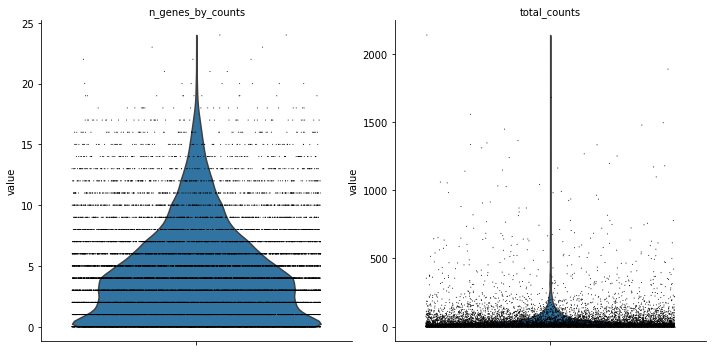

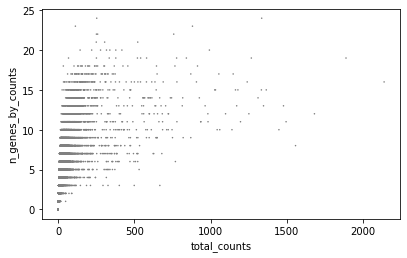

In [6]:
# data quality check
sc.pp.calculate_qc_metrics(adata_endo, percent_top=None, inplace=True, log1p=False)
sc.pl.violin(adata_endo, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_endo, x='total_counts', y='n_genes_by_counts')

poor_expression_threshold: 3.0


<AxesSubplot:xlabel='total_counts', ylabel='Count'>

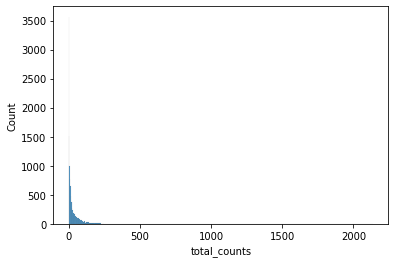

In [7]:
# exclude cells with too few or too many genes detected
poor_expression_threshold = np.percentile(adata_endo.obs['total_counts'], percentile_filter)
if (poor_expression_threshold == 0) | (np.isnan(poor_expression_threshold)):
    poor_expression_threshold = 1
print(f'poor_expression_threshold: {poor_expression_threshold}')

sns.histplot(adata_endo.obs['total_counts'])
# from the histrogram, determine the max_counts value below

filtered out 3565 cells that have less than 3.0 counts
>>> total cells passed the filter: 9289


Trying to set attribute `._uns` of view, copying.


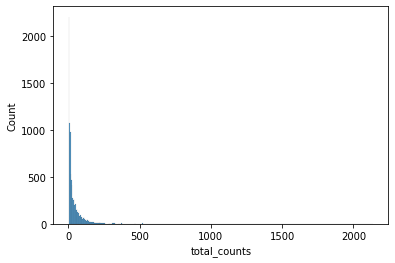

In [8]:
cell_subset, _ = sc.pp.filter_cells(adata_endo, min_counts=poor_expression_threshold, inplace=False)
cell_subset2, _ = sc.pp.filter_cells(adata_endo, max_counts=3000, inplace=False)
cell_subset = cell_subset & cell_subset2
gene_subset, number_per_gene = sc.pp.filter_genes(adata_endo, min_counts=1, inplace=False)

adata_endo = adata_endo[cell_subset, gene_subset]
adata_virus = adata_virus[cell_subset, :]
print(f'>>> total cells passed the filter: {adata_endo.n_obs}')
sns.histplot(adata_endo.obs['total_counts'])

adata_endo.uns['cell_subset'] = cell_subset

In [9]:
# normalizaton
sc.pp.normalize_total(adata_endo)
adata_endo.raw = adata_endo
sc.pp.scale(adata_endo)

normalizing counts per cell
    finished (0:00:00)


In [10]:
# clustering endogenous gene expression to find cell type clusters
sc.pp.pca(adata_endo)
sc.pp.neighbors(adata_endo, use_rep="X_pca", n_neighbors=n_neighbors)
sc.tl.umap(adata_endo)
sc.tl.tsne(adata_endo, use_rep="X_pca")
sc.tl.leiden(adata_endo, resolution=leiden_resolution)
sc.tl.dendrogram(
    adata_endo, groupby="leiden", use_rep="X_pca", linkage_method="complete"
)

computing PCA
    with n_comps=23
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:05:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:27)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [11]:
# copy the results of clustering to viral gene expression matrix
print(adata_endo)
anndata_copy_attributes(adata_endo, adata_virus)
print(adata_virus)
clustering_method = 'leiden'

AnnData object with n_obs × n_vars = 9289 × 24
    obs: 'position', 'overlap_in_stitched', 'cell_location', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'cell_subset', 'pca', 'neighbors', 'umap', 'tsne', 'leiden', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 9289 × 13
    obs: 'position', 'overlap_in_stitched', 'cell_location', 'n_genes_by_counts', 'total_counts', 'leiden'
    uns: 'cell_subset', 'pca', 'neighbors', 'umap', 'tsne', 'leiden', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'


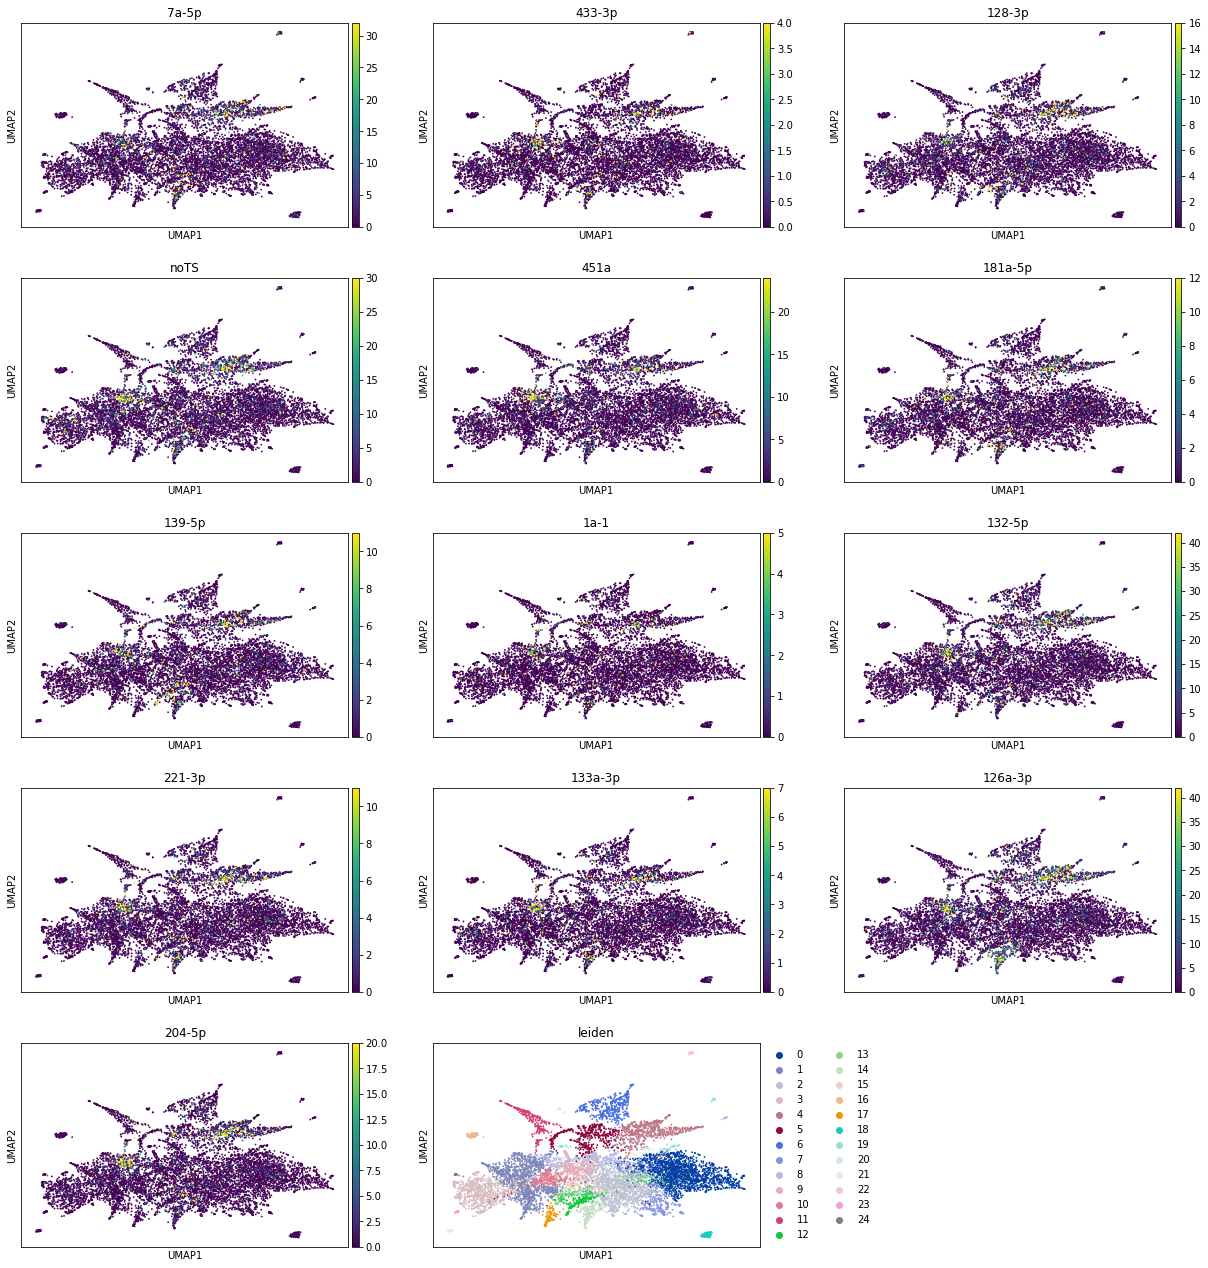

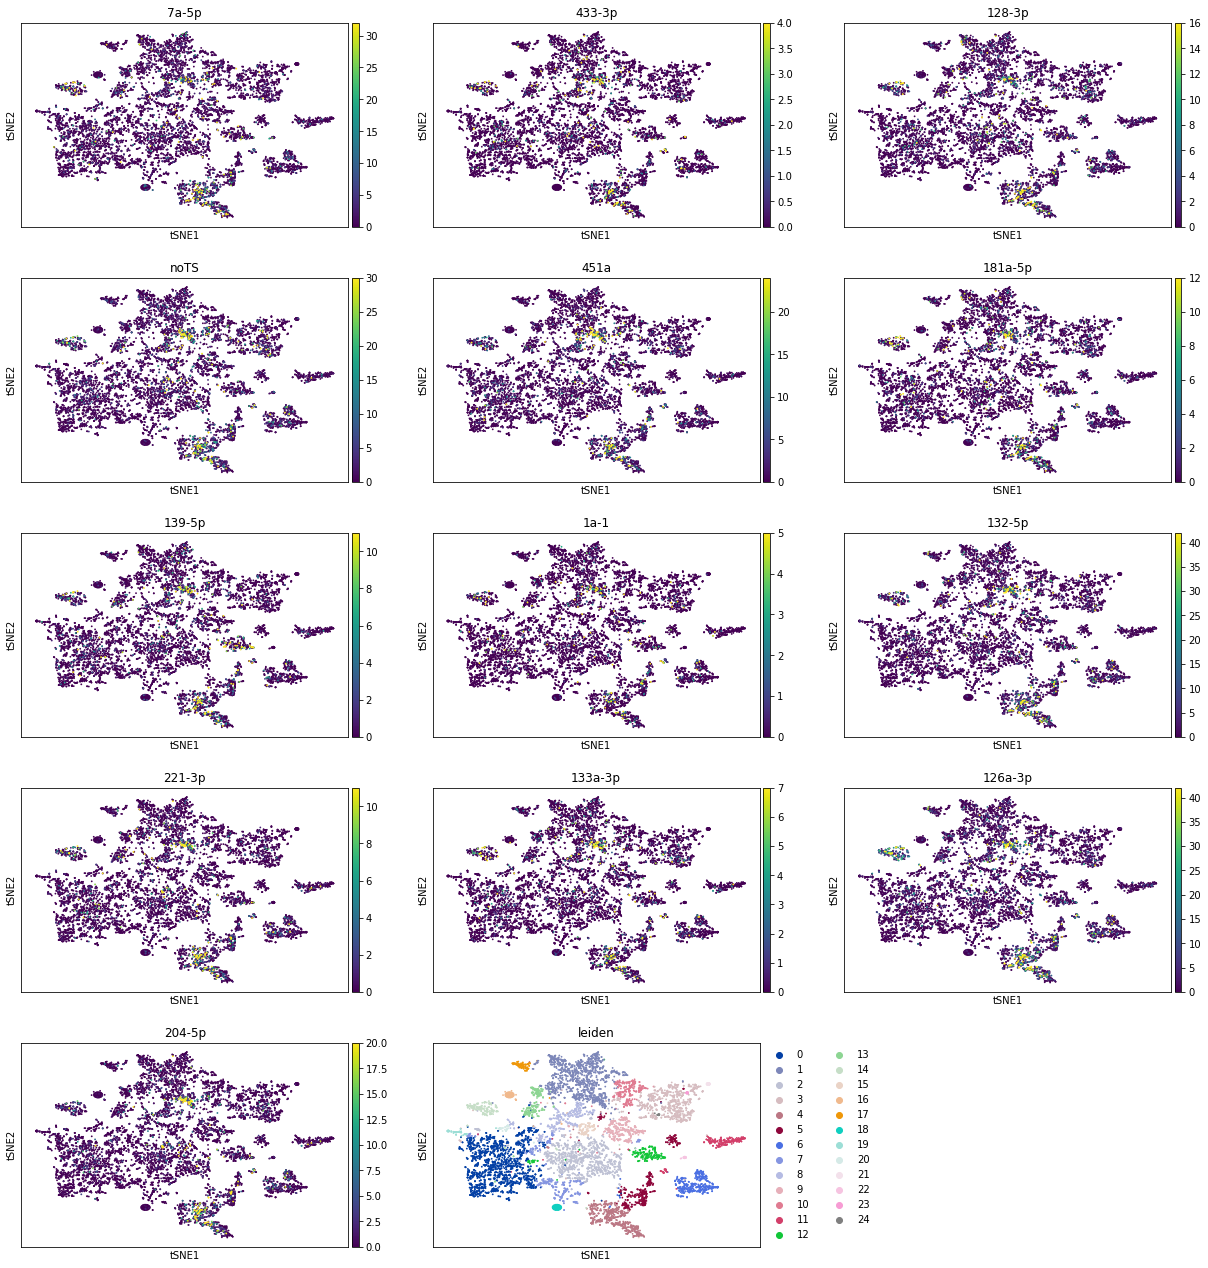

In [12]:
# umap and tsne plotting 
sc.pl.umap(
    adata_virus, 
    color=['7a-5p', '433-3p', '128-3p', 'noTS', '451a', '181a-5p', '139-5p', '1a-1', '132-5p', '221-3p', '133a-3p', '126a-3p', '204-5p','leiden'], 
    frameon=True, 
    ncols=3, 
    vmax='p99'
)
sc.pl.tsne(
    adata_virus, 
    color=['7a-5p', '433-3p', '128-3p', 'noTS', '451a', '181a-5p', '139-5p', '1a-1', '132-5p', '221-3p', '133a-3p', '126a-3p', '204-5p','leiden'], 
    frameon=True, 
    ncols=3, 
    vmax='p99'
)

<AxesSubplot:>

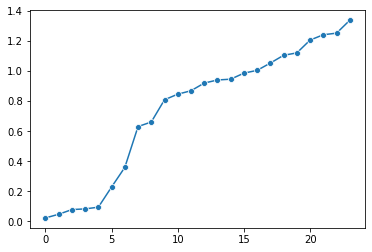

In [13]:
# cluster merging based on dendrogram distance
# find the target number of clusters (target_n_clusters)
dendrogram_name = 'dendrogram_' + clustering_method
linkage_matrix = adata_endo.uns[dendrogram_name]['linkage']

cluster_list = [str(idx) for idx in range(adata_endo.obs[clustering_method].nunique())]
adata_endo.obs[clustering_method] = adata_endo.obs[clustering_method].cat.rename_categories(cluster_list)

cluster_labels = np.asarray(adata_endo.obs[clustering_method]).astype(np.uint)
n_clusters = np.unique(cluster_labels).size
new_labels = {str(i):str(i) for i in range(n_clusters)}
p_threshold = 1e-3

sns.lineplot(
    x=np.array(range(linkage_matrix.shape[0])), 
    y=linkage_matrix[:,2],
    marker='o',
)

In [14]:
# cluster merging based on dendrogram distance
# new result of clustering is stored as "leiden_new"
target_n_clusters = 18
n_merging_branches = n_clusters - target_n_clusters
for iter in range(n_merging_branches):
    cluster1 = int(linkage_matrix[iter, 0])
    cluster2 = int(linkage_matrix[iter, 1])

    cluster_labels[np.argwhere(cluster_labels==cluster1).ravel()] = n_clusters
    cluster_labels[np.argwhere(cluster_labels==cluster2).ravel()] = n_clusters
    
    cinds = [i for i, cluster in new_labels.items() if cluster==str(cluster1)]
    for cind in cinds:
        new_labels[cind] = str(n_clusters)
    cinds = [i for i, cluster in new_labels.items() if cluster==str(cluster2)]
    for cind in cinds:
        new_labels[cind] = str(n_clusters)
    
    n_clusters = n_clusters + 1

adata_endo.obs['leiden_new'] = adata_endo.obs[clustering_method].map(new_labels).astype('category')

Trying to set attribute `.obs` of view, copying.


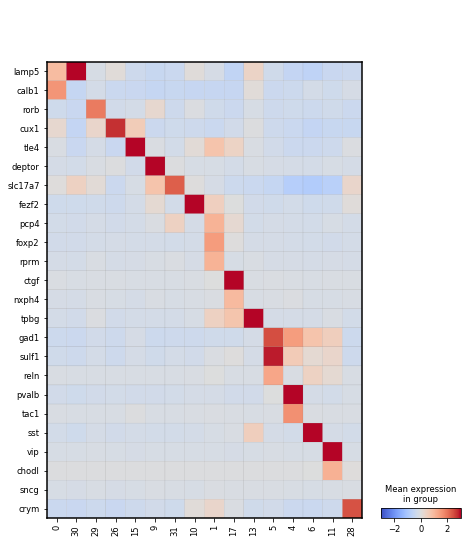

In [15]:
# cluster ordering for visualization
leiden_idx_reordered_int = [
    0, 30, 
    29, 26, 15,              
    9,                       
    31, 10,                  
    1,                       
    17, 13,                  
    5, 4, 6, 11,             
    28                       
]
poor_idx = ['12', '14']

gene_list_ordered = [
    'noTS', 
    '1a-1', '7a-5p', '126a-3p', '128-3p','132-5p', 
    '133a-3p', '139-5p', '181a-5p', '204-5p', '221-3p', '433-3p', '451a', 
    'lamp5', 'calb1', 
    'rorb', 'cux1', 'tle4',
    'deptor', 'slc17a7',  
    'fezf2','pcp4', 'foxp2', 'rprm', 
    'ctgf', 'nxph4', 'tpbg',
    'gad1', 'sulf1', 'reln', 'pvalb','tac1', 'sst', 'vip', 'chodl','sncg', 
    'crym'
]

cells_outlier_cluster = adata_endo.obs['leiden_new'].isin(poor_idx)
adata_endo = adata_endo[~cells_outlier_cluster,:]
adata_virus = adata_virus[~cells_outlier_cluster,:]


leiden_idx_reordered = [str(idx) for idx in leiden_idx_reordered_int]
# leiden_idx_reordered = list(np.unique(adata_endo.obs['leiden_new']))
adata_endo.obs['leiden_new'] = adata_endo.obs['leiden_new'].cat.reorder_categories(leiden_idx_reordered)

img = sc.pl.MatrixPlot(
    adata_endo,
    gene_list_ordered[len(virus_list):],
    'leiden_new',
    categories_order=leiden_idx_reordered,
    use_raw=False,
    vmax=vmax,
    vmin=vmin
).style(cmap=cmap_z).swap_axes()
img.show()

Text(0.5, 1.0, 'log2 fold change')

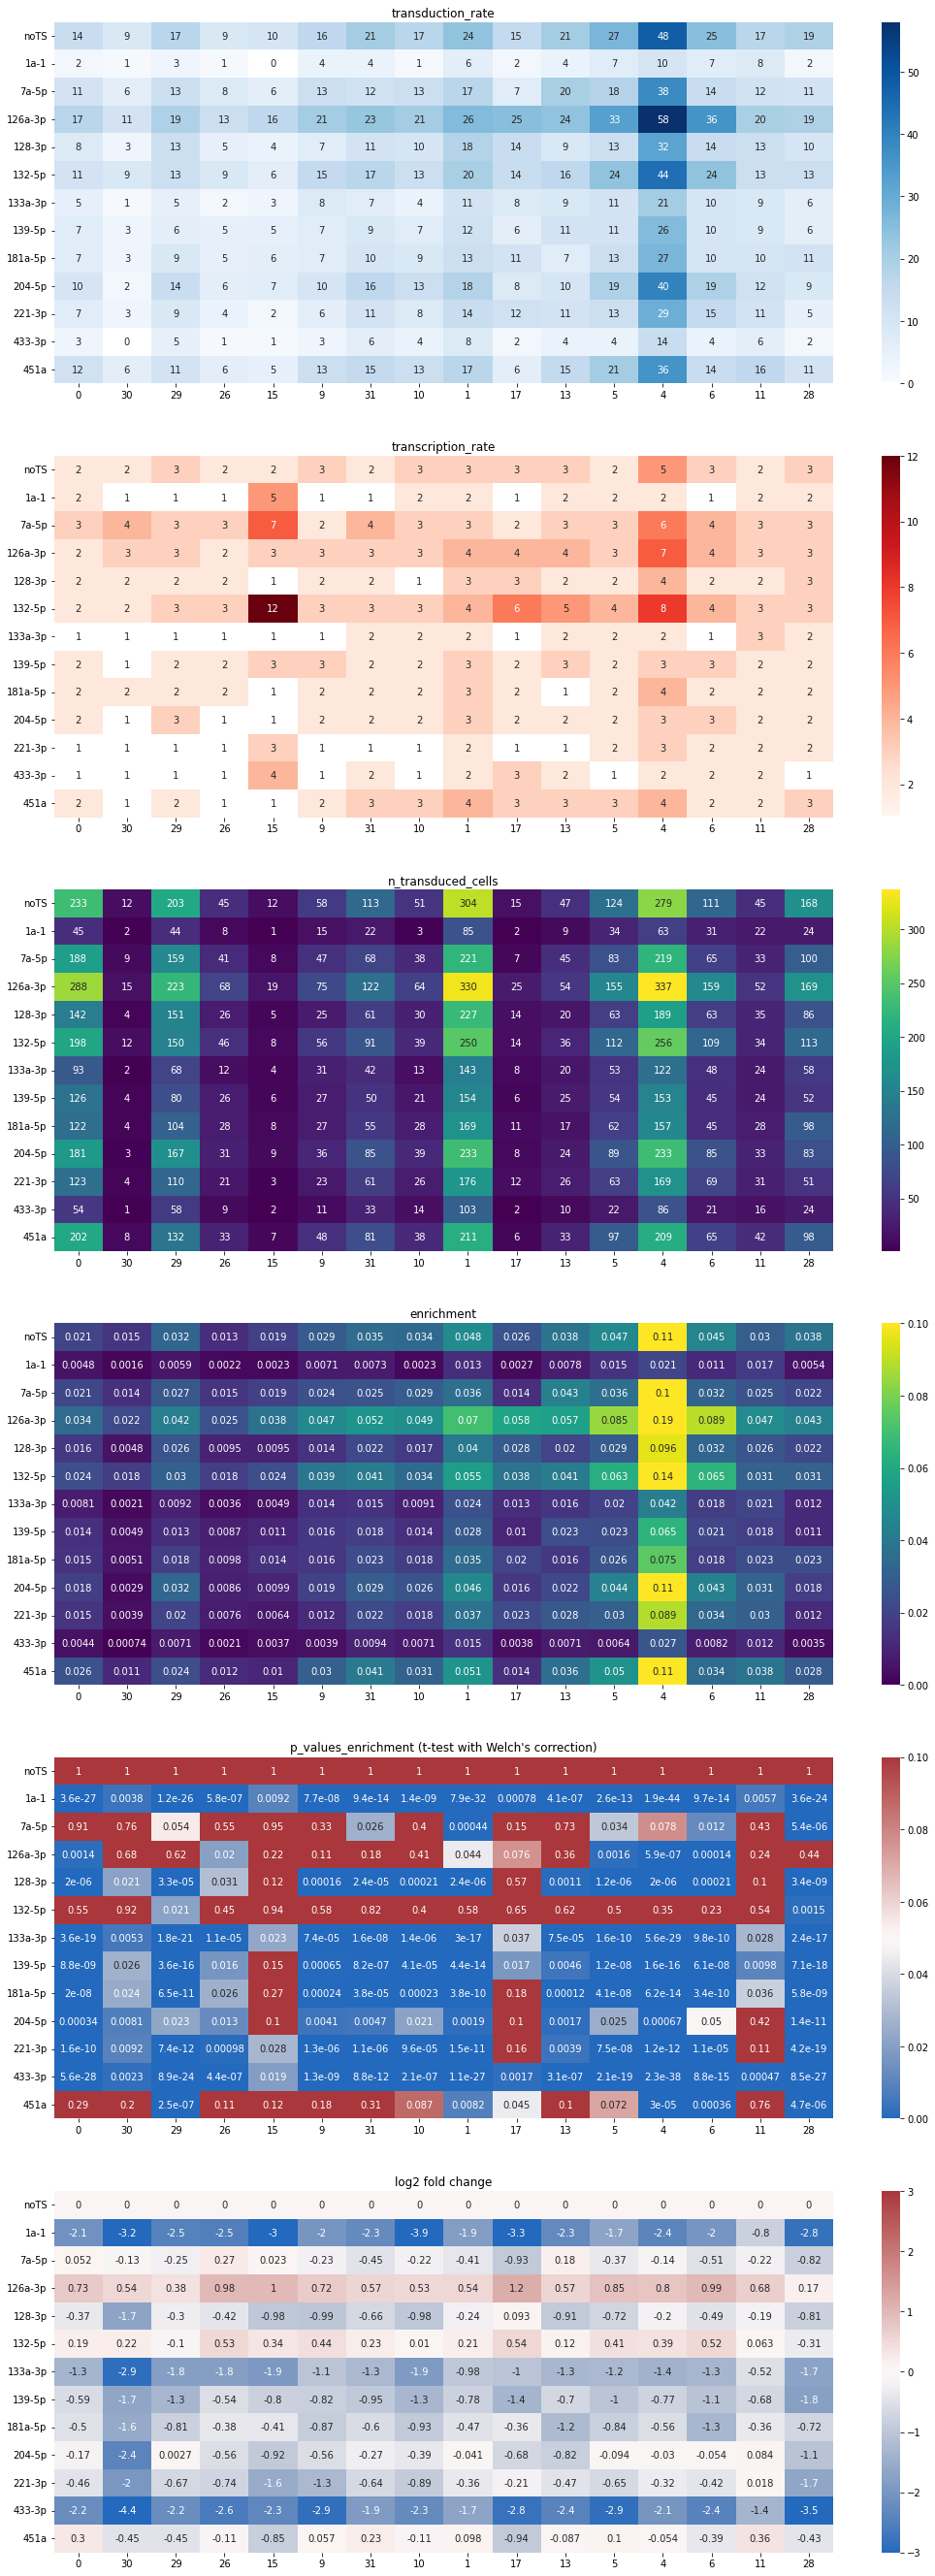

In [19]:
# quantification
from scipy.stats import ttest_ind

cluster_labels = list(np.unique(adata_endo.obs['leiden_new']))
n_clusters = len(cluster_labels)
n_variants = adata_virus.n_vars

transduction_rate = np.zeros((n_variants, n_clusters), dtype=np.uint)
transcription_rate = np.zeros((n_variants, n_clusters), dtype=np.uint)
enrichment = np.zeros((n_variants, n_clusters))
n_transduced_cells = np.zeros((n_variants, n_clusters), dtype=np.uint)
p_values_enrichment = np.zeros((n_variants, n_clusters), dtype=np.float)
n_total_cells = np.zeros((n_clusters,), dtype=np.uint)

for v, virus in enumerate(virus_list):
    for c, cluster in enumerate(leiden_idx_reordered):
        cell_inds = (adata_endo.obs['leiden_new']==cluster)
        n_cell_in_cluster = cell_inds.sum()
        n_total_cells[c] = n_cell_in_cluster
        transduction_rate[v,c] = np.count_nonzero(adata_virus[cell_inds, virus].X)*100. / n_cell_in_cluster
        enrichment[v,c] = np.mean(np.log1p(adata_virus[cell_inds, virus].X.ravel()))
        nonzeros = (adata_virus[cell_inds, virus].X != 0).ravel()
        n_transduced_cells[v,c] = nonzeros.sum()
        tcpr = np.median(adata_virus[cell_inds, virus].X[nonzeros].ravel())
        if ~np.isnan(tcpr):
            transcription_rate[v,c] = tcpr

        nots = np.log1p(adata_virus[cell_inds, 'noTS'].X.ravel())
        virus_values = np.log1p(adata_virus[cell_inds, virus].X.ravel())
        _, p = ttest_ind(nots, virus_values, equal_var=False)
        p_values_enrichment[v,c] = p

enrichment = enrichment/np.array(titer)[:,np.newaxis]
log2foldchange_enrichment = np.log2(enrichment) - np.log2(enrichment[0,:])

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm

blues_zero_white = LinearSegmentedColormap.from_list('', ['white', *cm.Blues(np.arange(255))])
reds_zero_white = LinearSegmentedColormap.from_list('', ['white', *cm.Reds(np.arange(255))])

fig, axs = plt.subplots(6, 1, figsize=(18,48))
sns.heatmap(
    data=transduction_rate, 
    cmap=blues_zero_white, 
    xticklabels=leiden_idx_reordered,
    yticklabels=virus_list, 
    ax=axs[0],
    annot=True,
)
axs[0].set_title("transduction_rate")

sns.heatmap(
    data=transcription_rate, 
    cmap=reds_zero_white, 
    xticklabels=leiden_idx_reordered,
    yticklabels=virus_list, 
    ax=axs[1],
    annot=True,
)
axs[1].set_title("transcription_rate")

sns.heatmap(
    data=n_transduced_cells,
    cmap='viridis',
    xticklabels=leiden_idx_reordered,
    yticklabels=virus_list,
    ax=axs[2],
    annot=True,
    fmt="d"
)
axs[2].set_title("n_transduced_cells")

sns.heatmap(
    data=enrichment,
    cmap='viridis',
    xticklabels=leiden_idx_reordered,
    yticklabels=virus_list,
    ax=axs[3],
    annot=True,
    vmax=0.1,
    vmin=0
)
axs[3].set_title("enrichment")

sns.heatmap(
    data=p_values_enrichment,
    cmap='vlag',
    xticklabels=leiden_idx_reordered,
    yticklabels=virus_list,
    ax=axs[4],
    annot=True,
    vmax=0.1,
    vmin=0
)
axs[4].set_title("p_values_enrichment (t-test with Welch's correction)")

sns.heatmap(
    data=log2foldchange_enrichment,
    cmap='vlag',
    xticklabels=leiden_idx_reordered,
    yticklabels=virus_list,
    ax=axs[5],
    annot=True,
    vmax=3,
    vmin=-3,
)
axs[5].set_title("log2 fold change")

In [20]:
# napari visualization
clustering_method = 'leiden_new'
n_clusters = np.unique(list(adata_endo.obs[clustering_method])).size

cell_labels_stitched = zarr.load('./example/cell_labels_stitched.zarr')
cell_cmap = get_cmap('rainbow', n_clusters)
cell_colors = [rgb2hex(cell_cmap(i)) for i in range(n_clusters)]
cell_coords = []
for cluster in leiden_idx_reordered:
    print(f'cluster: {cluster}')
    cell_locations_str = np.asarray(adata_endo[(adata_endo.obs[clustering_method]==cluster)].obs['cell_location'])
    print(len(cell_locations_str))
    cell_locations = []
    for cell_loc in cell_locations_str:
        cell_loc_float = [float(coord) for coord in re.findall(r'[\d]*[.]+', cell_loc)]
        cell_locations.append(cell_loc_float)

    print(np.array(cell_locations).shape)
    cell_coords.append(np.array(cell_locations))

viewer = napari.Viewer()

viewer.add_labels(
    cell_labels_stitched,
    name='cell_labels',
    multiscale=False
)

for c, cell_coord in enumerate(cell_coords):
    viewer.add_points(
        cell_coord,
        face_color=cell_colors[c],
        edge_color=cell_colors[c],
        size=100,
        n_dimensional=True,
        name=f'cluster {leiden_idx_reordered[c]}',
        blending='additive',
        visible=False
    )


# n_transcript_max = adata_virus.X.max()
n_transcript_max = 50
n_transcript_min = adata_virus.X.min()

cell_locations_str = np.asarray(adata_virus.obs['cell_location'])
cell_locations = []
for cell_loc in cell_locations_str:
    cell_loc_float = [float(coord) for coord in re.findall(r'[\d]*[.]+', cell_loc)]
    cell_locations.append(cell_loc_float)

properties={
    'color': np.linspace(0, 1, len(cell_locations))
}
viewer.add_points(
    cell_locations,
    properties=properties,
    face_color='color',
    face_colormap='rainbow',
    size=100,
    n_dimensional=True,
    name='cell_labels_points',
    blending='additive',
    visible=False
)

for virus in virus_list:
    exp = np.array(adata_virus[:,virus].X.ravel() / (n_transcript_max-n_transcript_min))    
    transduced = list(np.argwhere(exp > 0).ravel())
    properties = {
        'expression': exp[transduced]
    }
    cell_transduced_locations = [cell_locations[i] for i in transduced]
    viewer.add_points(
        cell_transduced_locations,
        properties=properties,
        face_color='expression',
        # face_colormap='Greys',    # for saving
        face_colormap='gray',       # for napari visualization
        face_contrast_limits=(0., 1.),
        size=100,
        n_dimensional=True,
        name=virus,
        blending='additive',
        visible=False
    )

cluster: 0
1652
(1652, 2)
cluster: 30
129
(129, 2)
cluster: 29
1150
(1150, 2)
cluster: 26
495
(495, 2)
cluster: 15
118
(118, 2)
cluster: 9
356
(356, 2)
cluster: 31
527
(527, 2)
cluster: 10
291
(291, 2)
cluster: 1
1235
(1235, 2)
cluster: 17
100
(100, 2)
cluster: 13
219
(219, 2)
cluster: 5
458
(458, 2)
cluster: 4
574
(574, 2)
cluster: 6
441
(441, 2)
cluster: 11
259
(259, 2)
cluster: 28
857
(857, 2)
